#### Jeffrey Bradley, Taylor Tucker, Virginia Weston
#### Test 2
#### Prof. Watson
#### 10/20/2020

# Support Vector Machine

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import jaccard_score

Confusion matrix plot function used in previous work

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
df = pd.read_csv('CleanedData.csv')
df.drop(columns = "Unnamed: 0", inplace = True)
columns = df.columns
df

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,SES Percentage,Asian,african american,latinx,white,Chance of Admit
0,337.0,118.0,4,4.5,4.5,9.65,1,12,1,0,0,0,0.92
1,324.0,107.0,4,4.0,4.5,8.87,1,11,0,0,1,0,0.76
2,316.0,104.0,3,3.0,3.5,8.00,1,78,0,0,1,0,0.72
3,322.0,110.0,3,3.5,2.5,8.67,1,77,0,0,0,1,0.80
4,314.0,103.0,2,2.0,3.0,8.21,0,1,0,1,0,0,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,324.0,110.0,3,3.5,3.5,9.04,1,60,0,0,0,1,0.82
352,325.0,107.0,3,3.0,3.5,9.11,1,30,0,0,1,0,0.84
353,330.0,116.0,4,5.0,4.5,9.45,1,99,0,0,0,1,0.91
354,312.0,103.0,3,3.5,4.0,8.78,0,12,0,1,0,0,0.67


Similar to our decision trees method AND Logistic Regression method, SVMs are binary classification so we will convert the Chance of admit to ones and zeros based on a threshold set by the median.

In [10]:
median_value = df["Chance of Admit"].median()
print(median_value)

0.73


Since the median chance of admission is 73%, I will use that as the threshold. Any chance of admission >= 0.73 will be
set to one, and any student < 0.73 will be set to 0

In [11]:
for i in range(len(df["Chance of Admit"])):
    if df.loc[i, "Chance of Admit"] >= 0.73:
        df.loc[i, "Chance of Admit"] = 1
    else:
        df.loc[i, "Chance of Admit"] = 0
print(df["Chance of Admit"])

0      1.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
351    1.0
352    1.0
353    1.0
354    0.0
355    1.0
Name: Chance of Admit, Length: 356, dtype: float64


In [12]:
x = df.iloc[:,:12]
x

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,SES Percentage,Asian,african american,latinx,white
0,337.0,118.0,4,4.5,4.5,9.65,1,12,1,0,0,0
1,324.0,107.0,4,4.0,4.5,8.87,1,11,0,0,1,0
2,316.0,104.0,3,3.0,3.5,8.00,1,78,0,0,1,0
3,322.0,110.0,3,3.5,2.5,8.67,1,77,0,0,0,1
4,314.0,103.0,2,2.0,3.0,8.21,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
351,324.0,110.0,3,3.5,3.5,9.04,1,60,0,0,0,1
352,325.0,107.0,3,3.0,3.5,9.11,1,30,0,0,1,0
353,330.0,116.0,4,5.0,4.5,9.45,1,99,0,0,0,1
354,312.0,103.0,3,3.5,4.0,8.78,0,12,0,1,0,0


In [13]:
y = df['Chance of Admit']

As seen in Logistic Regression, Robust Scaler improved accuracy the most, so we will be using it here aswell

In [14]:
x_RS = preprocessing.RobustScaler().fit_transform(x)

In [15]:
xRS_train, xRS_test, yRS_train, yRS_test = train_test_split(x_RS, y, test_size=0.3)

In [34]:
SVM = SVC(kernel='linear', C=1.0, random_state=1)
SVM.fit(xRS_train, yRS_train)
yhatSVM = SVM.predict(xRS_test)
yhatSVM

array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
       0., 0., 1., 0., 0.])

### Results

In [35]:
jaccard_score(yRS_test, yhatSVM)

0.828125

In [36]:
print (classification_report(yRS_test, yhatSVM))

              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89        49
         1.0       0.90      0.91      0.91        58

    accuracy                           0.90       107
   macro avg       0.90      0.90      0.90       107
weighted avg       0.90      0.90      0.90       107



Confusion matrix, without normalization
[[53  5]
 [ 6 43]]


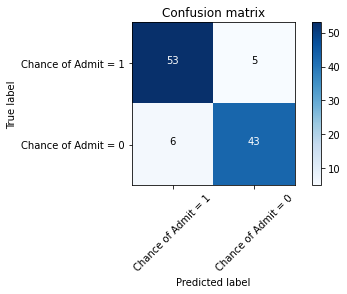

In [37]:
CM = confusion_matrix(yRS_test, yhatSVM, labels=[1,0])
#np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(CM, classes=['Chance of Admit = 1','Chance of Admit = 0'],normalize= False,  title='Confusion matrix')

### Conclusions

SVM appears to have done the best out of all the binary classifiers we used on this data set